This notebook is a quick introduction to the sparse representation set out by M. Carrasco-Kind and R. J. Brunner in their paper arxiv.org:1404.6442. The original code is freely available here:https://github.com/mgckind/SparsePz together with the paper pdf and notebook tutorials. The code is not python3 compliant though.
As a functional form for the representation basis, they used a Voigt profile, which generalizes a Gaussian to larger tails (It is in essence a convolution between a gaussian and a Cauchy distribution). This notebook exercizes the functionalities coded in the module qp/sparse_rep.py : look there for further comments on the implementation.

In [1]:
import sys, os
import qp
import numpy as np
from scipy import linalg as sla
from scipy import special
from scipy import integrate as sciint
from scipy import interpolate as sciinterp
from matplotlib import pylab as plt
from astropy.io import fits as pf
%matplotlib inline
%config Completer.use_jedi = False

We load the data : pdf examples from either qp or the original SparsePz package

In [2]:
Ntot = 10 #limit the number of pdfs for testing. Set to -1 to load all pdfs
if True:
    filein = '/home/cohen/lsst/codes/pipelines/photoz/SparsePz/CFHTLens_sample.P.npy'
    #FORMAT FILE, EACH ROW IS THE PDF FOR EACH GALAXY, LAST ROW IS THE REDSHIFT POSITION
    P = np.load(filein)
    z = P[-1]
    ens_red = qp.Ensemble(qp.interp, data=dict(xvals=z, yvals=P[:Ntot]))

else:
    ens = qp.read('qp_test_ensemble.hdf5')
    z = ens.metadata()['xvals'][0]
    if Ntot != -1:
        ens_red = ens[np.arange(Ntot)]
    else:
        ens_red = ens
P = ens_red.objdata()['yvals']

We want to enforce normalisation, just in case the input pdfs are not properly normalized, and we want to optimize the grid used for sparse representation over the whole considered sample (the same grid needs to be used for every pdf in the sample). We use trapezoidal rule as a fast integrator and likely a sufficient precision for our purpose.

In [3]:
P = P/sciint.trapz(P,z).reshape(-1,1)

In [4]:
minz = np.min(z)
nz = 301
i,j=np.where(P>0)
maxz=np.max(z[j+1])
newz=np.linspace(minz, maxz, nz)
interp = sciinterp.interp1d(z,P, assume_sorted=True)
newpdf = interp(newz)
newpdf = newpdf / sciint.trapz(newpdf,newz).reshape(-1,1)

In [5]:
##check the pdfs if the Ntot is not too large
#plt.plot(z,P.T); plt.plot(newz,newpdf.T,'-'); plt.xlim(minz,maxz);

The following call builds the sparse representation: *Sparse_Indices* is the NobjxNsparse array of encoded indices (Nobj=number f object in the sample and Nsparse maximum number of bases used for the representation), *meta* is the metadata used to build the representation, and *A* is the Voigt nzxNbasis basis array (nz is the number of values where the bases are evaluated, and Nbasis is the number of bases used). *sparse_rep.build_sparse_representation* accepts several more arguments to define the basis array. This step takes 0.2s/object, and is trivially parallelizable over the set of object.

In [6]:
Sparse_Indices, meta, A = qp.sparse_rep.build_sparse_representation(newz, newpdf, verbose=False)

When the basis array A is available, one can reconstruct the pdf without needing the metadata:

In [7]:
pdf_y = qp.sparse_rep.pdf_from_sparse(Sparse_Indices, A, newz, cut=1.e-5)

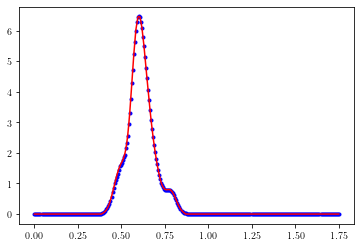

In [8]:
k=3
plt.plot(newz, pdf_y[:,k], '.b')
plt.plot(newz, newpdf[k], '-r')
#plt.xlim((0.19,0.2))
#plt.ylim((-0.1,0.2))

<ipython-input-9-f61e69891963>:1: RuntimeWarning: invalid value encountered in true_divide
  ratio = (pdf_y[:,k]-newpdf[k])/pdf_y[:,k]


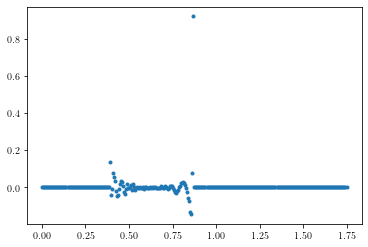

In [9]:
ratio = (pdf_y[:,k]-newpdf[k])/pdf_y[:,k]
# remove numerical instability close to 0:
ratio = np.where(newpdf[k]<1.e-5,0,ratio)
plt.plot(newz, ratio,'.')
#plt.xlim((0.19,0.2))


In the residual plot above, the large values occur at the transition where both the intial and reconstructed pdf reach 0, and thus is a numerical artefact without serious consequences.

It is important to note that the sparse representation is *not* a functional representation : the reconstructed pdf is evaluated at the grid of points used to build the matrix *A*. Interpolation is required in a scheme where the reconstructed pdf needs to be evaluated anywhere, as in qp.

In the case where qp reads a file with a sparse encoding of the objects, the matrix A will not be available, and needs to be rebuilt based on the metadata

In [10]:
A = qp.sparse_rep.create_voigt_basis(meta['xvals'], meta['mu'], meta['dims'][0], meta['sig'], meta['dims'][1]\
                                , meta['dims'][2], cut=1.e-5)

If needed, one can also retrieve the shape parameters of the Voigt representations, and use these to reconstruct the pdf

In [11]:
#Next decode the sparse indices into the voigt shape parameters
wa, ma, sa, ga = qp.sparse_rep.indices2shapes(Sparse_Indices, meta)
pdf_shape = qp.sparse_rep.shapes2pdf(wa[k], ma[k], sa[k], ga[k], meta)

In [12]:
np.allclose(pdf_shape,pdf_y[:,k])


True

In [13]:
#writing to a fits file, as originally proposed in SparsePz
if False:
    print('Writing fits file (example_out.fits)')

    head = pf.Header()
    head['N_TOT'] = Ntot
    head['N_MU'] = bigD['dims'][0]
    head['N_SIGMA'] = bigD['dims'][1]
    head['N_VOIGT'] = bigD['dims'][2]
    head['N_COEF'] = bigD['dims'][3]
    head['N_SPARSE'] = bigD['N_SPARSE']
    head['MU1'] = bigD['mu'][0]
    head['MU2'] = bigD['mu'][1]
    head['SIGMA1'] = bigD['sig'][0]
    head['SIGMA2'] = bigD['sig'][1]

    col1 = pf.Column(name='redshift', format='E', array=bigD['z'])
    fmt = '%dJ' % bigD['N_SPARSE']
    col2 = pf.Column(name='Sparse_indices', format=fmt, array=ALL)
    table1 = pf.BinTableHDU.from_columns(pf.ColDefs([col1]))
    table2 = pf.BinTableHDU.from_columns(pf.ColDefs([col2]))
    prihdu = pf.PrimaryHDU(header=head)
    hdulist = pf.HDUList([prihdu, table1, table2])
    hdulist.writeto('example_out.fits', overwrite=True)


In [14]:
# So now we can also create a qp ensemble
ens_sparse = qp.Ensemble(qp.sparse, data=dict(sparse_indices=Sparse_Indices, sparse_meta=meta))

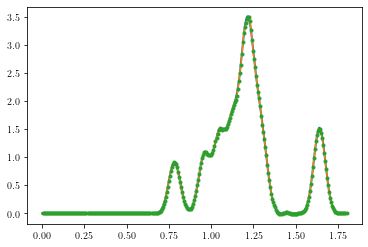

In [15]:
plt.plot(newz, newpdf[8], linewidth=2)
plt.plot(meta['xvals'], ens_sparse.pdf(meta['xvals'])[8])
#interpolation works
newx = np.linspace(0.005,1.8,300)
plt.plot(newx, ens_sparse.pdf(newx)[8], '.')

In [20]:
#this is broken
ens_sparse.plot(key=8, label="PDF 1")

TypeError: __init__() missing 2 required positional arguments: 'sparse_indices' and 'sparse_meta'

In [17]:
#We can also turn the gridded initial representation (the input file) into the sparse representation by conversion.
ens_sparse = qp.convert(ens_red, 'sparse')

Total Galaxies =  10
dx =  0.005810066889632109
Nmu, Nsig, Nv =  [ 300 , 50 , 3 ]
Total bases in dictionary 45000
Nsparse (number of bases) =  20
Creating Dictionary...
Creating Sparse representation...
done


In [18]:
#we check that we do have the sparse indices and metadata accessible
ens_sparse.gen_obj.sparse_indices.shape, ens_sparse.gen_obj.sparse_meta['dims']

((10, 20), [300, 50, 3, 32001])

In [21]:
# This tries to create the ensemble with a class that inherits from interp_gen directly, and it fails
ens_sparse2 = qp.Ensemble(qp.sparse2, data=dict(sparse_indices=Sparse_Indices, sparse_meta=meta))

TypeError: __init__() got multiple values for argument 'xvals'